- have minor issues and some inconsistencies so refer to Lab4_utils.py file the rest is good.

# Building your Deep Learning Neural Network: Step by Step

## 1. Packages:

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42)

## Initialization:

### 3.1 2-layer Neural Network

create and initialize the parameters of a 2-layer neural network.

In [ ]:
def initialize(n_x, n_h, n_y):
    np.random.seed(42)

    w1 = np.random.randn(n_x, n_h) * 0.01
    b1 = np.zeros((n_h, 1))
    w2 = np.random.randn(n_h, n_y) * 0.01
    b2 = np.zeros((n_y, 1))

    assert(w1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(w2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))

    params = {'w1': w1,
              'b1': b1, 
              'w2': w2,
              'b2': b2}

    return params



In [24]:
parameters = initialize(3,2,1)
print("W1 = " + str(parameters["w1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["w2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.00496714 -0.00138264]
 [ 0.00647689  0.0152303 ]
 [-0.00234153 -0.00234137]]
b1 = [[0.]
 [0.]]
W2 = [[0.01579213]
 [0.00767435]]
b2 = [[0.]]


implementing for an L-layer Neural Network the initialization of weights.

In [5]:
def initialize_deep(layer_dims):
    # layer_dims: it is a list containing dimensions of each layer in our network
    np.random.seed(42)
    params = {}
    L = len(layer_dims)

    for i in range(1, L):
        params['w' + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
        params['b' + str(i)] = np.zeros((layer_dims[i], 1))


    return params

## 4. Forward Propagation module

### 4.1 Linear Forward

building this in 3 parts:
1. Linear
2. Linear -> Activation
3. (Linear -> ReLU) X (L - 1) -> Linear -> Sigmoid (whole model)

In [6]:
# building the linear part
def linear_forward(A, W, b):

    z = np.dot(W, A) + b

    assert(z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return z, cache

In [9]:
def sigmoid(z):
    A = 1 / (1 + np.exp(-z))

    cache = z
    return A, cache

In [10]:
def relu(z):
    A = np.maximum(0, z)
    cache = z
    return A, z

In [11]:
def sigmoid_backward(da, cache):
    """
        Arguments:
        dA -- post-activation gradient, of any shape
        cache -- 'Z' stored from forward propagation 
    """
    z = cache
    s = 1 / (1+np.exp(-z))
    dz = da * s * ( 1- s)
    return dz


In [12]:
def relu_backward(da, cache):
    z = cache
    dz = np.array(da, copy=True) # converting to correct obj.
    dz[z <= 0] = 0 # gradient be 0 if z <= 0.
    return dz

### 4.2 Linear Activaton Forward:
using two sigmoid and relu

In [13]:
def linear_activation_forward(A_prev, W, b, activation):

    z, cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(z)

    elif activation == 'relu':
        A, activation_cache = relu(z)

    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (cache, activation_cache)
    
    return A, cache

In [15]:
# implementing the L-Layer Model
def model_propagate(x, params):
    caches = []
    A = x
    L = len(params)
    for i in range(1, L):
        A_prev = A
        w = params['w' + str(i)]
        b = params['b' + str(i)]
        A, cache = linear_activation_forward(A_prev, w, b, "relu")
        caches.append(cache)

    w = params['w' + str(i)]
    b = params['b' + str(i)]
    Al, cache = linear_activation_forward(A, w, b, "relu")
    caches.append(cache)

    assert(Al.shape == (1, x.shape[1]))

    return Al, caches



## 5. Cost function 
the same cross-entropy loss to check

In [ ]:
def compute_cost(Al, y):
    m = y.shape[1]

    cost =  -(1/m) *  np.sum(np.multiply(y, np.log(Al)) + np.multiply((1-y), np.log(1- Al)))
    cost = np.squeeze(cost) # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    return cost


## 6. Backward Propagation Module:

we will break it down in 3 parts too.
LINEAR backward
LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
[LINEAR -> RELU] × (L-1) -> LINEAR -> SIGMOID backward (whole model)

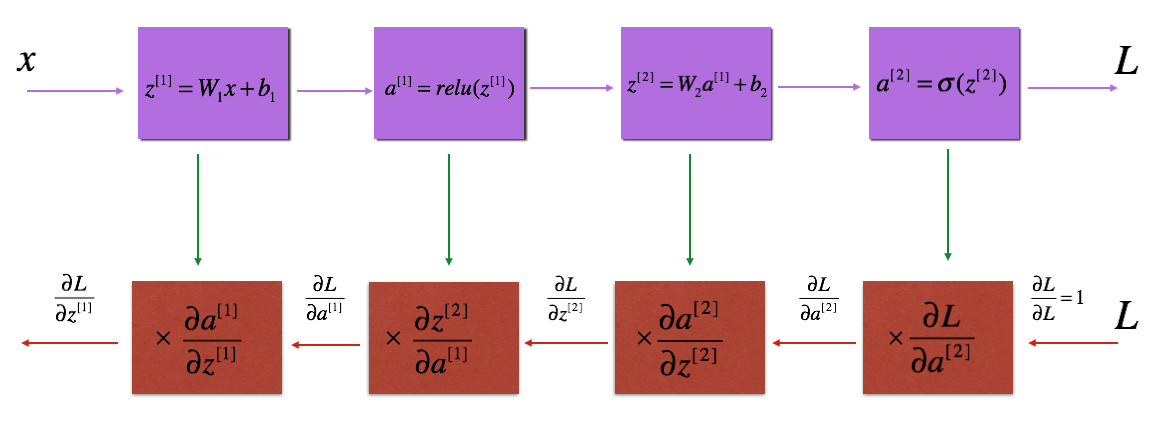

In [19]:
def linear_backward(dz, cache):
    A_prev, w, b, = cache
    m = A_prev.shape[1]

    dw = 1/m * np.dot(dz, A_prev.T)
    db = 1/m * np.sum(dz, axis=1, keepdims=True)
    dA_prev = np.dot(w.T, dz)

    assert (dA_prev.shape == A_prev.shape)
    assert (dw.shape == w.shape)
    assert (db.shape == b.shape)
    return dA_prev, dw, db


### 6.2 Linear-Activation backward:

In [20]:
def linear_activation_backward(da, cache, activation):
    l_cache, a_cache = cache
    if(activation == "relu"):
        dz = relu_backward(da, a_cache)
        dA_prev, dw, db = linear_backward(dz, l_cache)

    elif activation == "sigmoid":
        dz = sigmoid_backward(da, a_cache)
        dA_prev, dw, db = linear_activation_backward(dz, l_cache)

    return dA_prev, dw, db


### 6.3 now L-Model Backward:
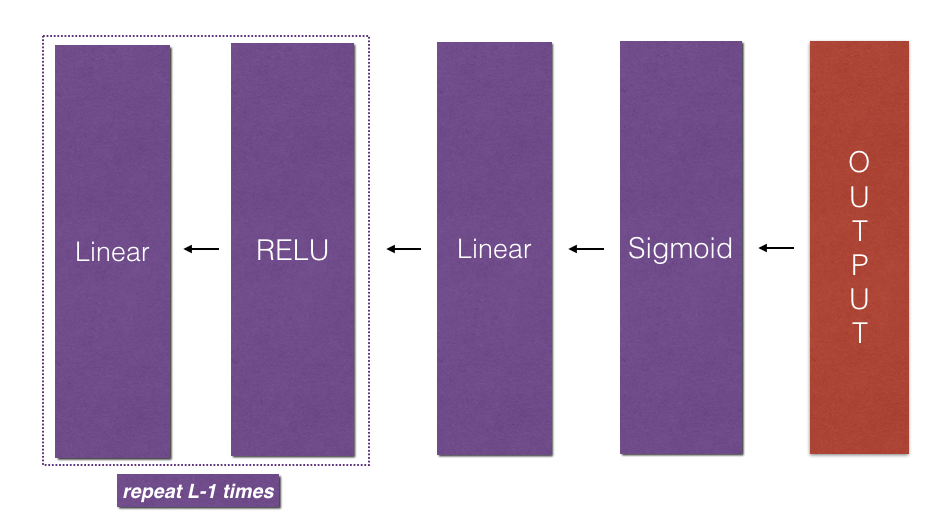

In [21]:
def L_model_backward(al, y, cache):
    grads = {}
    l = len(cache) # the no. of layers
    m = al.shape[1]
    y = y.reshape(al.shape)

    dal = - (np.divide(y, al) - np.divide(1-y, 1-al)) # derivative of cost with respect to al

    curr_cache = cache[l-1]
    grads['da'+str(l-1)], grads['dw'+str(l)], grads['db'+str(l)] = linear_activation_backward(dal, curr_cache, "sigmoid")

    for i in reversed(range(l-1)):
        curr_cache = cache[i]
        da_prev_temp, dw_temp, db_temp = linear_activation_backward(grads['da'+str(i+1)], curr_cache, "relu")
        grads['da'+str(i)] = da_prev_temp
        grads['dw'+str(i)] = dw_temp
        grads['db'+str(i)]=db_temp

    return grads


#### 6.4 Update parameters:


In [23]:
def update_params(grads, params, lr):
    l = len(params) // 2 # no. of layers in nn
    for i in range(l):
        params['w'+str(i+1)] = params['w'+str(i+1)] - lr*grads['dw'+str(i+1)]
        params['b'+str(i+1)] = params['b'+str(i+1)] - lr*grads['db'+str(i+1)]
    return params

### 7. Conclusion

we have build functions that are required to bulid a deep neural network!